In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import wordcloud
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import chi2

# Load Dataset

In [2]:
df=pd.read_csv('lemmatized_bt_augment_train.csv')
test_df=pd.read_csv('lemmatized_original_test.csv')

df.head()

,Unnamed: 0,text,sentiment,lemmatized and stopwords_removed
0,0,should uber use driverless cars to ease safety...,0,uber use driverless car ease safety concern
1,1,oh hai minorityreport is making your driverles...,0,oh hai minorityreport driverless transportatio...
2,2,who is responsible if a self driving car gets ...,0,responsible self drive car accident
3,3,i almost got rear ended by the google car iron...,-1,got rear end google car ironic
4,4,self driving cars will be a hit until the firs...,-1,self drive car hit family hit algorithm sue


In [3]:
df.drop(columns=['Unnamed: 0'], inplace=True)
test_df.drop(columns=['Unnamed: 0'], inplace=True)

print(df.shape)
print(test_df.shape)

(8162, 3)
(1341, 3)


In [4]:
X_train = df['lemmatized and stopwords_removed']
y_train = df['sentiment']
X_test = test_df['lemmatized and stopwords_removed']
y_test = test_df['sentiment']

# Generating n-grams

In [5]:
# TfidfVectorizer (Unigram)  
corpus = X_train

vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), token_pattern=u"(?u)\\b\\w+\\b", min_df=10)

train_counts_unigram = vectorizer.fit_transform(corpus)
test_counts_unigram = vectorizer.transform(X_test)

# initialize vectorized text dataframe
df_vectorized_text_unigrams_train = pd.DataFrame(data=train_counts_unigram.toarray(), columns=vectorizer.get_feature_names())
df_vectorized_text_unigrams_test = pd.DataFrame(data=test_counts_unigram.toarray(), columns=vectorizer.get_feature_names())

################################################################

# TfidfVectorizer (Unigram & Bigram)  
corpus = X_train

vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), token_pattern=u"(?u)\\b\\w+\\b", min_df=10)

train_counts_unigram_and_bigram = vectorizer.fit_transform(corpus)
test_counts_unigram_and_bigram = vectorizer.transform(X_test)

# initialize vectorized text dataframe
df_vectorized_text_unigrams_and_bigrams_train = pd.DataFrame(data=train_counts_unigram_and_bigram.toarray(), columns=vectorizer.get_feature_names())
df_vectorized_text_unigrams_and_bigrams_test = pd.DataFrame(data=test_counts_unigram_and_bigram.toarray(), columns=vectorizer.get_feature_names())

In [6]:
df_vectorized_text_unigrams_train.shape

(8162, 837)

# Multinomial NB- Baseline (unigrams only)

## Training without Chi Square Feature Selection

In [7]:
X_train = df_vectorized_text_unigrams_train
X_test = df_vectorized_text_unigrams_test

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 67.73%
Test Accuracy: 65.40%
Test F1 Score: 65.55%
Mean Cross Val Accuracy: 62.56%
Mean Cross Val F1 Score: 61.90%
Testing Matthew's coefficient: 0.357


## Training with Chi2 feature selection

In [8]:
# 0 is chi2 score, 1 is p-value
X_train = df_vectorized_text_unigrams_train
X_test = df_vectorized_text_unigrams_test

chi2_values = chi2(X_train.values, y_train)
chi2_df = pd.DataFrame(data=chi2_values, columns=X_train.columns)
chi2_df_sorted = chi2_df.sort_values(by=0, axis = 1, ascending = False)
chi2_df_sorted

,cool,wait,want,awesome,problem,trust,amazing,scare,love,fbi,...,pay,minute,ground,miss,wire,student,bike,early,enter,steve
0,1.094770e+02,7.493332e+01,5.675188e+01,4.491590e+01,4.273535e+01,4.195628e+01,3.889217e+01,3.830791e+01,3.443056e+01,3.242461e+01,...,0.060477,0.054338,0.050844,0.050158,0.027308,0.022072,0.007958,0.003961,0.001943,0.000051
1,1.687975e-24,5.351016e-17,4.747718e-13,1.764556e-10,5.249715e-10,7.750152e-10,3.586513e-09,4.803331e-09,3.338101e-08,9.100940e-08,...,0.970214,0.973197,0.974898,0.975233,0.986439,0.989025,0.996029,0.998021,0.999029,0.999974


## Finding the optimal number of features to use based on cross validation F1-score

In [9]:
f1_results_unigram_chi_square = {}
for n in range(1, 837, 5):
    chi2_columns_unigrams = chi2_df_sorted.columns[:n]
    X_train_df = df_vectorized_text_unigrams_train[chi2_columns_unigrams]

    clf = MultinomialNB()

    #Cross validation, cv=5
    f1 = cross_val_score(clf, X_train_df, y_train, scoring='f1_weighted', cv=5)
    
    #Storing mean cross validation F1-scores in a dictionary
    f1_results_unigram_chi_square[n] = f1.mean() 

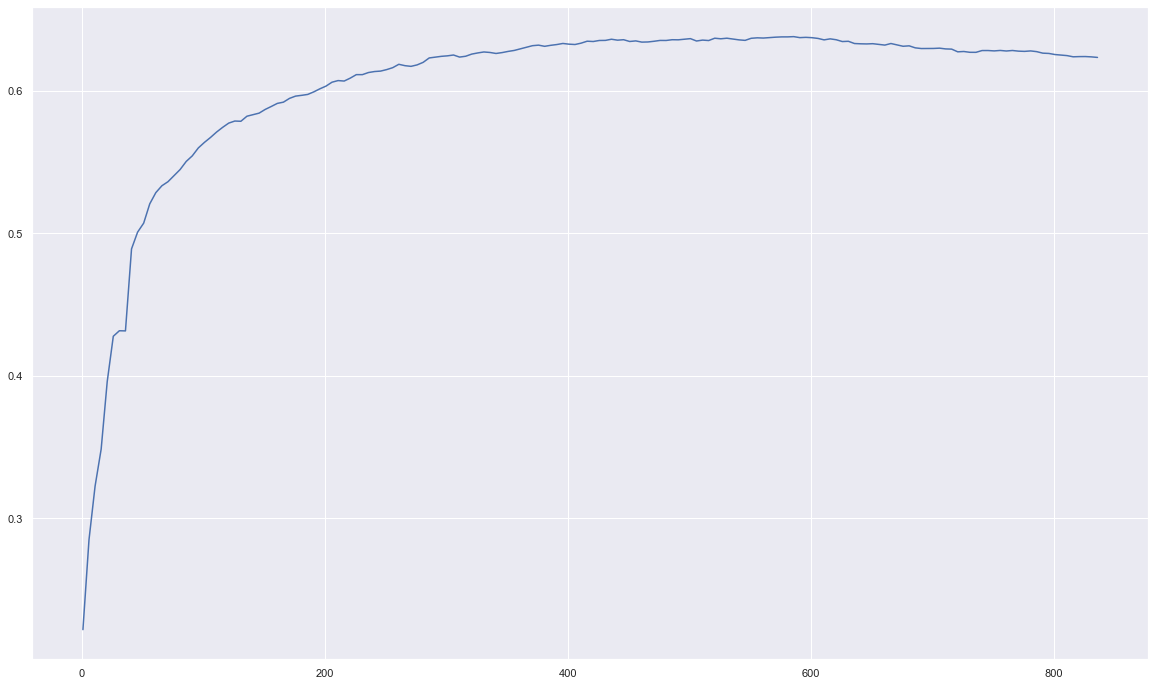

In [10]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(data=f1_results_unigram_chi_square)

In [11]:
# Getting the optimal number of features which will result in best mean cross validation F1-score from the dictionary

best_no_of_features= max(f1_results_unigram_chi_square, key=f1_results_unigram_chi_square.get)
best_no_of_features

586

In [12]:
# Extracting the optimal number of features into a dataframe for training

chi2_columns = chi2_df_sorted.columns[:best_no_of_features]
X_train_vectorized_unigrams_chi_square = df_vectorized_text_unigrams_train[chi2_columns]
X_test_vectorized_unigrams_chi_square = df_vectorized_text_unigrams_test[chi2_columns]

In [13]:
X_train = X_train_vectorized_unigrams_chi_square
X_test = X_test_vectorized_unigrams_chi_square

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 67.74%
Test Accuracy: 66.29%
Test F1 Score: 66.36%
Mean Cross Val Accuracy: 64.35%
Mean Cross Val F1 Score: 63.67%
Testing Matthew's coefficient: 0.374


# Unigrams + bigrams results

## Training without Chi Square Feature Selection

In [14]:
X_train = df_vectorized_text_unigrams_and_bigrams_train
X_test = df_vectorized_text_unigrams_and_bigrams_test

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 69.32%
Test Accuracy: 65.92%
Test F1 Score: 66.11%
Mean Cross Val Accuracy: 63.13%
Mean Cross Val F1 Score: 62.64%
Testing Matthew's coefficient: 0.371


## Training with Chi Square Feature Selection

In [15]:
# 0 is chi2 score, 1 is p-value
X_train = df_vectorized_text_unigrams_and_bigrams_train
X_test = df_vectorized_text_unigrams_and_bigrams_test

chi2_values = chi2(X_train.values, y_train)
chi2_df = pd.DataFrame(data=chi2_values, columns=X_train.columns)
chi2_df_sorted = chi2_df.sort_values(by=0, axis = 1, ascending = False)
chi2_df_sorted

,cool,wait,problem,want,awesome,trust,amazing,scare,wait self,love,...,wire,car actually,bike,google plan,feel lucky,enter,pay,early,student,steve
0,8.708846e+01,5.723568e+01,3.701021e+01,3.670220e+01,3.569579e+01,3.466529e+01,3.300328e+01,3.240834e+01,3.164995e+01,2.956964e+01,...,0.028203,0.018620,0.018184,0.017357,0.016723,0.015785,0.012140,0.010780,0.005156,0.003583
1,1.227383e-19,3.727611e-13,9.190396e-09,1.072059e-08,1.773197e-08,2.968439e-08,6.814415e-08,9.175267e-08,1.340607e-07,3.793451e-07,...,0.985997,0.990733,0.990949,0.991359,0.991673,0.992139,0.993949,0.994625,0.997425,0.998210


## Finding the optimal number of features to use based on cross validation F1-score

In [16]:
f1_results_unigram_bigram = {}
for n in range(1, 1200, 5):
    chi2_columns_unigram_bigram = chi2_df_sorted.columns[:n]
    X_train_df = df_vectorized_text_unigrams_and_bigrams_train[chi2_columns_unigram_bigram]

    clf = MultinomialNB()

    #Cross validation, cv=5
    f1 = cross_val_score(clf, X_train_df, y_train, scoring='f1_weighted', cv=5)
    
    #Storing mean cross validation F1-scores in a dictionary
    f1_results_unigram_bigram[n] = f1.mean() 

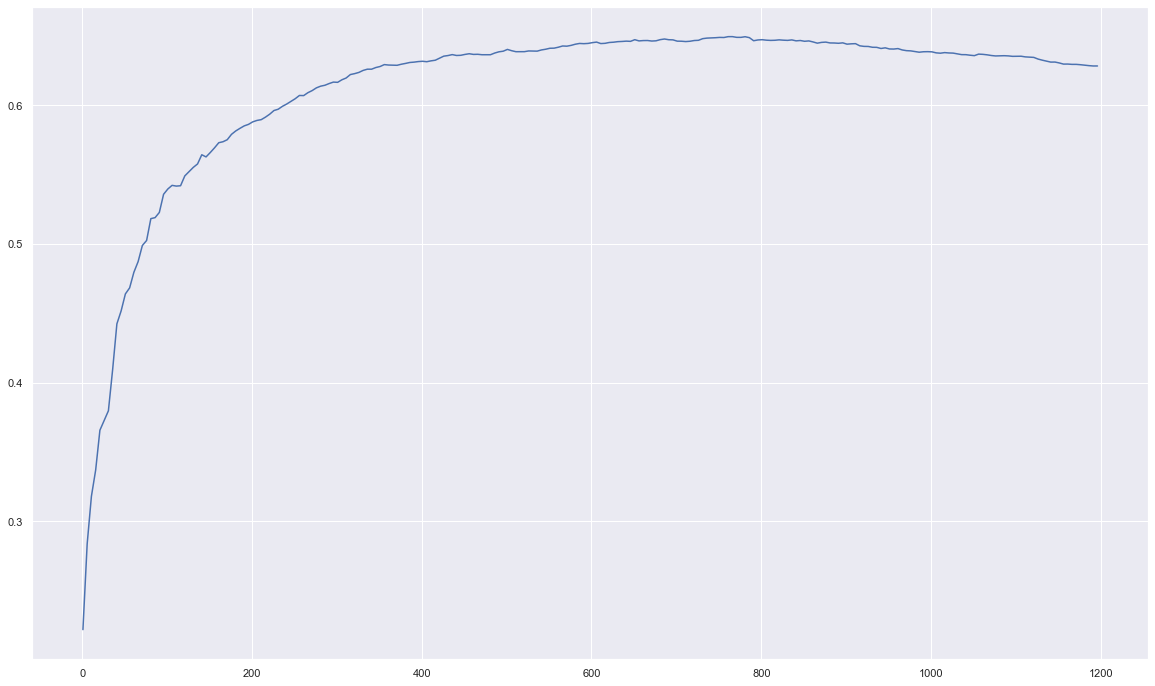

In [17]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(data=f1_results_unigram_bigram)

In [18]:
# Getting the optimal number of features which will result in best mean cross validation F1-score from the dictionary

best_no_of_features= max(f1_results_unigram_bigram, key=f1_results_unigram_bigram.get)
best_no_of_features

766

In [19]:
# Extracting the optimal number of features into a dataframe for training

chi2_columns = chi2_df_sorted.columns[:best_no_of_features]
X_train_vectorized_unigram_bigram_chi_square = df_vectorized_text_unigrams_and_bigrams_train[chi2_columns]
X_test_vectorized_unigram_bigram_chi_square = df_vectorized_text_unigrams_and_bigrams_test[chi2_columns]

In [20]:
X_train = X_train_vectorized_unigram_bigram_chi_square
X_test = X_test_vectorized_unigram_bigram_chi_square

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 68.81%
Test Accuracy: 67.34%
Test F1 Score: 67.11%
Mean Cross Val Accuracy: 65.28%
Mean Cross Val F1 Score: 64.63%
Testing Matthew's coefficient: 0.38


# Unigrams + Bigrams + Unsupervised Topics

In [21]:
unsupervised_topics=[(1,
  [('autonomous', 0.12041249620867456),
   ('vehicle', 0.10737033666969972),
   ('driving', 0.05338186229905975),
   ('tech', 0.03306035790112223),
   ('auto', 0.02456778889899909),
   ('insurance', 0.02305125872004853),
   ('nissan', 0.01668183196845617),
   ('law', 0.01637852593266606),
   ('toyota', 0.014255383682135275),
   ('robotic', 0.011828935395814377),
   ('hate', 0.010615711252653927),
   ('automate', 0.010615711252653927),
   ('research', 0.010312405216863815),
   ('industry', 0.009705793145283591),
   ('impact', 0.009099181073703366),
   ('require', 0.008492569002123142),
   ('connected', 0.008492569002123142),
   ('michigan', 0.008492569002123142),
   ('completely', 0.00818926296633303),
   ('study', 0.00818926296633303),
   ('university', 0.007279344858962694),
   ('sell', 0.006976038823172581),
   ('team', 0.006976038823172581),
   ('win', 0.006672732787382469),
   ('arbor', 0.006369426751592357),
   ('ann', 0.006369426751592357),
   ('center', 0.006066120715802244),
   ('motor', 0.005762814680012132),
   ('semi', 0.005762814680012132),
   ('fake', 0.00545950864422202)]),
 (2,
  [('wait', 0.06664609688367788),
   ('ride', 0.04813329219376736),
   ('great', 0.035791422400493676),
   ('watch', 0.03363159518667078),
   ('idea', 0.032088861462511574),
   ('find', 0.01974699166923789),
   ('parking', 0.01974699166923789),
   ('lot', 0.019438444924406047),
   ('park', 0.01666152422091947),
   ('service', 0.016044430731255787),
   ('lexus', 0.015427337241592102),
   ('government', 0.01511879049676026),
   ('hand', 0.014810243751928418),
   ('roll', 0.012650416538105523),
   ('imagine', 0.01203332304844184),
   ('man', 0.01203332304844184),
   ('share', 0.01203332304844184),
   ('home', 0.010490589324282628),
   ('light', 0.010182042579450786),
   ('camera', 0.008947855600123419),
   ('pull', 0.008330762110459735),
   ('passenger', 0.008330762110459735),
   ('pick', 0.008330762110459735),
   ('blind', 0.008022215365627893),
   ('child', 0.007713668620796051),
   ('meet', 0.007405121875964209),
   ('dog', 0.007405121875964209),
   ('lead', 0.007405121875964209),
   ('shit', 0.006788028386300524),
   ('la', 0.006170934896636841)]),
 (3,
  [('google', 0.12093308778391651),
   ('time', 0.05586249232658073),
   ('nt', 0.03591160220994475),
   ('buy', 0.030079803560466543),
   ('apple', 0.024248004910988337),
   ('long', 0.022713321055862493),
   ('awesome', 0.021485573971761818),
   ('company', 0.019643953345610803),
   ('smart', 0.015346838551258441),
   ('phone', 0.015039901780233272),
   ('news', 0.014732965009208104),
   ('wo', 0.011663597298956415),
   ('nice', 0.011663597298956415),
   ('check', 0.011663597298956415),
   ('hear', 0.010128913443830571),
   ('forward', 0.010128913443830571),
   ('invest', 0.009208103130755065),
   ('sit', 0.008594229588704727),
   ('scary', 0.008594229588704727),
   ('dangerous', 0.008594229588704727),
   ('play', 0.008287292817679558),
   ('spend', 0.008287292817679558),
   ('game', 0.008287292817679558),
   ('android', 0.008287292817679558),
   ('small', 0.007059545733578883),
   ('head', 0.007059545733578883),
   ('mobile', 0.006752608962553714),
   ('app', 0.006445672191528545),
   ('age', 0.006445672191528545),
   ('campus', 0.006138735420503376)]),
 (4,
  [('google', 0.14017521902377972),
   ('problem', 0.03660826032540676),
   ('traffic', 0.0353566958698373),
   ('human', 0.03285356695869837),
   ('pass', 0.03097622027534418),
   ('good', 0.025344180225281603),
   ('speed', 0.01939924906132666),
   ('feel', 0.019086357947434292),
   ('turn', 0.0172090112640801),
   ('bring', 0.015644555694618274),
   ('solve', 0.013454317897371715),
   ('lane', 0.012828535669586983),
   ('limit', 0.011889862327909888),
   ('change', 0.011889862327909888),
   ('report', 0.00969962453066333),
   ('challenge', 0.00969962453066333),
   ('travel', 0.009073842302878598),
   ('totally', 0.008760951188986232),
   ('solution', 0.008760951188986232),
   ('miss', 0.008448060075093867),
   ('mainstream', 0.008135168961201502),
   ('wtf', 0.008135168961201502),
   ('major', 0.007509386733416771),
   ('bike', 0.0071964956195244055),
   ('concern', 0.00688360450563204),
   ('nyc', 0.006257822277847309),
   ('potential', 0.006257822277847309),
   ('waste', 0.005944931163954944),
   ('purchase', 0.005632040050062578),
   ('apparently', 0.005632040050062578)]),
 (5,
  [('google', 0.18500154942671213),
   ('technology', 0.06259683916950728),
   ('ready', 0.03563681437867989),
   ('legal', 0.027269910133250697),
   ('map', 0.025720483421134182),
   ('spot', 0.023241400681747754),
   ('state', 0.019832661915091417),
   ('ford', 0.017043693833281685),
   ('morning', 0.01673380849085838),
   ('guy', 0.01580415246358847),
   ('innovation', 0.015494267121165169),
   ('money', 0.013325069724202046),
   ('pic', 0.013015184381778741),
   ('sound', 0.012395413696932134),
   ('learn', 0.010226216299969011),
   ('goog', 0.009916330957545709),
   ('perfect', 0.009296560272699102),
   ('nevada', 0.008986674930275797),
   ('florida', 0.008676789587852495),
   ('face', 0.008676789587852495),
   ('gm', 0.00836690424542919),
   ('cruise', 0.007437248218159281),
   ('decade', 0.007437248218159281),
   ('cheap', 0.006817477533312674),
   ('fuck', 0.006507592190889371),
   ('commute', 0.006197706848466067),
   ('ahead', 0.005887821506042764),
   ('trend', 0.005887821506042764),
   ('stanford', 0.005577936163619461),
   ('base', 0.005577936163619461)]),
 (6,
  [('wheel', 0.0640625),
   ('california', 0.0615625),
   ('test', 0.0525),
   ('build', 0.0396875),
   ('steering', 0.0384375),
   ('prototype', 0.0221875),
   ('audi', 0.021875),
   ('unveil', 0.0190625),
   ('break', 0.0178125),
   ('start', 0.0159375),
   ('develop', 0.015625),
   ('pedal', 0.015625),
   ('brake', 0.014375),
   ('license', 0.0125),
   ('googleplex', 0.0125),
   ('worth', 0.011875),
   ('seat', 0.011875),
   ('sign', 0.0115625),
   ('bill', 0.0109375),
   ('permit', 0.010625),
   ('testing', 0.0103125),
   ('approve', 0.0096875),
   ('ce', 0.0090625),
   ('hell', 0.0084375),
   ('dmv', 0.0084375),
   ('trillion', 0.0075),
   ('release', 0.0075),
   ('san', 0.0071875),
   ('button', 0.0065625),
   ('post', 0.0059375)]),
 (7,
  [('future', 0.1156773211567732),
   ('year', 0.049010654490106546),
   ('happen', 0.026788432267884323),
   ('tesla', 0.026484018264840183),
   ('big', 0.026484018264840183),
   ('good', 0.025266362252663623),
   ('truck', 0.02161339421613394),
   ('amazing', 0.019178082191780823),
   ('highway', 0.01796042617960426),
   ('fun', 0.015525114155251141),
   ('control', 0.014611872146118721),
   ('mt', 0.011872146118721462),
   ('reality', 0.011263318112633182),
   ('sleep', 0.0106544901065449),
   ('week', 0.010350076103500762),
   ('cyclist', 0.01004566210045662),
   ('codecon', 0.01004566210045662),
   ('inside', 0.009741248097412482),
   ('ceo', 0.008828006088280061),
   ('fully', 0.00821917808219178),
   ('datum', 0.00821917808219178),
   ('yeah', 0.007914764079147641),
   ('bmw', 0.007914764079147641),
   ('exciting', 0.007914764079147641),
   ('guess', 0.0076103500761035),
   ('bet', 0.0076103500761035),
   ('power', 0.0076103500761035),
   ('tv', 0.0073059360730593605),
   ('tech', 0.007001522070015221),
   ('model', 0.006697108066971081)]),
 (8,
  [('cool', 0.07112201103617413),
   ('uber', 0.05947271612507664),
   ('taxi', 0.040159411404046594),
   ('view', 0.026364193746167996),
   ('pretty', 0.023911710606989576),
   ('real', 0.020846106683016553),
   ('job', 0.019313304721030045),
   ('train', 0.018087063151440833),
   ('electric', 0.01624770079705702),
   ('mountain', 0.014714898835070508),
   ('business', 0.014408338442673207),
   ('fleet', 0.013795217657878603),
   ('infrastructure', 0.011342734518700184),
   ('shit', 0.010116492949110975),
   ('detroit', 0.010116492949110975),
   ('economy', 0.00950337216431637),
   ('bad', 0.009196811771919068),
   ('reduce', 0.009196811771919068),
   ('race', 0.008890251379521767),
   ('sf', 0.008890251379521767),
   ('sense', 0.008583690987124463),
   ('googlecar', 0.008583690987124463),
   ('replace', 0.00827713059472716),
   ('start', 0.00827713059472716),
   ('destroy', 0.007664009809932557),
   ('million', 0.007664009809932557),
   ('exist', 0.007357449417535254),
   ('blame', 0.00674432863274065),
   ('machine', 0.006437768240343348),
   ('fuel', 0.0061312078479460455)]),
 (9,
  [('road', 0.08997828110456096),
   ('people', 0.08098045299410488),
   ('day', 0.038163201985727584),
   ('safe', 0.029785913744958113),
   ('trust', 0.027614024201054917),
   ('stop', 0.024201054917778467),
   ('public', 0.023890784982935155),
   ('crash', 0.023270245113248527),
   ('kill', 0.018926466025442134),
   ('place', 0.017064846416382253),
   ('wrong', 0.016134036611852313),
   ('bus', 0.014582686937635743),
   ('drunk', 0.014582686937635743),
   ('hour', 0.013651877133105802),
   ('die', 0.013341607198262488),
   ('valley', 0.012721067328575862),
   ('worry', 0.012721067328575862),
   ('issue', 0.012410797393732548),
   ('reason', 0.012100527458889234),
   ('death', 0.012100527458889234),
   ('silicon', 0.011479987589202606),
   ('pay', 0.010238907849829351),
   ('damn', 0.010238907849829351),
   ('agree', 0.008687558175612783),
   ('uk', 0.008067018305926156),
   ('hard', 0.007446478436239528),
   ('happy', 0.007136208501396215),
   ('begin', 0.007136208501396215),
   ('kid', 0.006515668631709587),
   ('decide', 0.006515668631709587)]),
 (10,
  [('google', 0.17111459968602827),
   ('thing', 0.05588697017268446),
   ('robot', 0.04144427001569859),
   ('hope', 0.02794348508634223),
   ('interesting', 0.02260596546310832),
   ('run', 0.021036106750392466),
   ('fast', 0.020094191522762952),
   ('dream', 0.015384615384615385),
   ('project', 0.015070643642072213),
   ('step', 0.012872841444270016),
   ('omg', 0.012558869701726845),
   ('internet', 0.01130298273155416),
   ('cute', 0.01098901098901099),
   ('program', 0.01098901098901099),
   ('past', 0.010675039246467817),
   ('true', 0.010361067503924647),
   ('drivingcar', 0.010047095761381476),
   ('finally', 0.010047095761381476),
   ('follow', 0.009733124018838305),
   ('pedestrian', 0.008791208791208791),
   ('area', 0.00816326530612245),
   ('thought', 0.00816326530612245),
   ('expect', 0.0075353218210361065),
   ('automaker', 0.007221350078492936),
   ('fb', 0.006593406593406593),
   ('search', 0.006593406593406593),
   ('vision', 0.006279434850863423),
   ('tonight', 0.005965463108320251),
   ('dear', 0.005337519623233909),
   ('massive', 0.005023547880690738)]),
 (11,
  [('google', 0.19200484554815264),
   ('street', 0.06359781950333132),
   ('city', 0.051181102362204724),
   ('accident', 0.03876438522107813),
   ('life', 0.03179890975166566),
   ('hit', 0.025439127801332527),
   ('mile', 0.020290732889158086),
   ('wow', 0.018473652331920047),
   ('save', 0.017867958812840704),
   ('lol', 0.01665657177468201),
   ('plan', 0.015445184736523319),
   ('free', 0.014536644457904301),
   ('googles', 0.012113870381586917),
   ('crazy', 0.01150817686250757),
   ('complete', 0.009993943064809207),
   ('house', 0.008782556026650516),
   ('master', 0.008782556026650516),
   ('open', 0.008479709267110842),
   ('person', 0.00817686250757117),
   ('deal', 0.007571168988491823),
   ('volvo', 0.006965475469412477),
   ('fall', 0.005754088431253785),
   ('number', 0.005754088431253785),
   ('concept', 0.005754088431253785),
   ('navigate', 0.005754088431253785),
   ('involve', 0.005451241671714113),
   ('fill', 0.00514839491217444),
   ('important', 0.00514839491217444),
   ('trip', 0.004845548152634767),
   ('announce', 0.004845548152634767)]),
 (12,
  [('work', 0.06364513018322084),
   ('today', 0.05914496946319511),
   ('love', 0.037608486017357765),
   ('video', 0.027965284474445518),
   ('talk', 0.026679524268723883),
   ('live', 0.0196078431372549),
   ('read', 0.01832208293153327),
   ('end', 0.016072002571520413),
   ('road', 0.014786242365798778),
   ('market', 0.014143362262937963),
   ('bad', 0.013821922211507553),
   ('article', 0.013500482160077145),
   ('home', 0.013500482160077145),
   ('safety', 0.01285760205721633),
   ('excited', 0.01285760205721633),
   ('system', 0.01253616200578592),
   ('ticket', 0.011893281902925105),
   ('space', 0.011571841851494697),
   ('office', 0.011571841851494697),
   ('transit', 0.011250401800064288),
   ('launch', 0.011250401800064288),
   ('story', 0.010607521697203472),
   ('change', 0.009964641594342655),
   ('cost', 0.009643201542912247),
   ('mass', 0.009643201542912247),
   ('picture', 0.00900032144005143),
   ('tweet', 0.008678881388621022),
   ('super', 0.008036001285760206),
   ('yesterday', 0.007714561234329798),
   ('friend', 0.007071681131468981)]),
 (13,
  [('google', 0.16856287425149702),
   ('world', 0.041916167664670656),
   ('glass', 0.027544910179640718),
   ('drone', 0.026347305389221556),
   ('design', 0.023952095808383235),
   ('transportation', 0.018263473053892216),
   ('fly', 0.016766467065868262),
   ('point', 0.01526946107784431),
   ('legalize', 0.01347305389221557),
   ('fbi', 0.012874251497005988),
   ('question', 0.012574850299401197),
   ('transport', 0.012275449101796407),
   ('invent', 0.012275449101796407),
   ('close', 0.011976047904191617),
   ('hurry', 0.011377245508982036),
   ('hey', 0.011077844311377245),
   ('computer', 0.010778443113772455),
   ('high', 0.010479041916167664),
   ('push', 0.009281437125748504),
   ('write', 0.008682634730538923),
   ('deliver', 0.008682634730538923),
   ('fear', 0.008083832335329342),
   ('weapon', 0.008083832335329342),
   ('warn', 0.0074850299401197605),
   ('easy', 0.0074850299401197605),
   ('delivery', 0.00718562874251497),
   ('stuff', 0.0068862275449101795),
   ('rule', 0.0068862275449101795),
   ('bomb', 0.006586826347305389),
   ('ad', 0.005988023952095809)])]

In [22]:
df_train_unsupervised_unigram_bigram=df.copy()
df_test_unsupervised_unigram_bigram=test_df.copy()

def assign_topic_score(text, topic_no):
    topic_list=unsupervised_topics[topic_no-1][1]    
    
    wordlist=text.split(' ')
    topic_score=0
    for word in wordlist:
        for word_weight in topic_list:
            if word==word_weight[0]:
                topic_score+=word_weight[1]
                
    return topic_score
    
for each_topic in unsupervised_topics:
    df_train_unsupervised_unigram_bigram['unsupervised_topic_' + str(each_topic[0])]= df_train_unsupervised_unigram_bigram.apply(lambda row: assign_topic_score(row['lemmatized and stopwords_removed'], each_topic[0]), axis=1)
    df_test_unsupervised_unigram_bigram['unsupervised_topic_' + str(each_topic[0])]= df_test_unsupervised_unigram_bigram.apply(lambda row: assign_topic_score(row['lemmatized and stopwords_removed'], each_topic[0]), axis=1)


## Training without Chi Square Feature Selection

## Preparing data for model training

In [23]:
df_train_unsupervised_unigram_bigram.head(3)

,text,sentiment,lemmatized and stopwords_removed,unsupervised_topic_1,unsupervised_topic_2,unsupervised_topic_3,unsupervised_topic_4,unsupervised_topic_5,unsupervised_topic_6,unsupervised_topic_7,unsupervised_topic_8,unsupervised_topic_9,unsupervised_topic_10,unsupervised_topic_11,unsupervised_topic_12,unsupervised_topic_13
0,should uber use driverless cars to ease safety...,0,uber use driverless car ease safety concern,0.000000,0.0,0.0,0.006884,0.0,0.0,0.0,0.059473,0.0,0.0,0.000000,0.012858,0.000000
1,oh hai minorityreport is making your driverles...,0,oh hai minorityreport driverless transportatio...,0.120412,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.036527
2,who is responsible if a self driving car gets ...,0,responsible self drive car accident,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.038764,0.000000,0.000000


In [24]:
# Scaling the Unsupervised topics

scaler = MinMaxScaler()
scaled_train_unsupervised_unigram_bigram = scaler.fit_transform(df_train_unsupervised_unigram_bigram.iloc[:, 3:])
scaled_test_unsupervised_unigram_bigram = scaler.transform(df_test_unsupervised_unigram_bigram.iloc[:, 3:])

# Transforming scaled topics into a dataframe

scaled_train_unsupervised_unigram_bigram_df = pd.DataFrame(scaled_train_unsupervised_unigram_bigram, columns = df_train_unsupervised_unigram_bigram.iloc[:, 3:].columns)
scaled_test_unsupervised_unigram_bigram_df = pd.DataFrame(scaled_test_unsupervised_unigram_bigram, columns = df_test_unsupervised_unigram_bigram.iloc[:, 3:].columns)

# Combining Unigrams + Bigrams + Unsupervised topics into one dataframe

train_unsupervised_unigram_bigram = pd.concat([scaled_train_unsupervised_unigram_bigram_df, df_vectorized_text_unigrams_and_bigrams_train], axis=1)
test_unsupervised_unigram_bigram = pd.concat([scaled_test_unsupervised_unigram_bigram_df, df_vectorized_text_unigrams_and_bigrams_test], axis=1)

In [25]:
train_unsupervised_unigram_bigram.head(3)

,unsupervised_topic_1,unsupervised_topic_2,unsupervised_topic_3,unsupervised_topic_4,unsupervised_topic_5,unsupervised_topic_6,unsupervised_topic_7,unsupervised_topic_8,unsupervised_topic_9,unsupervised_topic_10,...,wrong,wtf,wwdc,yay,yeah,year,yes,yesterday,yr,zero
0,0.000000,0.0,0.0,0.009821,0.0,0.0,0.0,0.360595,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.309914,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
X_train = train_unsupervised_unigram_bigram
X_test = test_unsupervised_unigram_bigram

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 68.97%
Test Accuracy: 66.52%
Test F1 Score: 66.77%
Mean Cross Val Accuracy: 62.56%
Mean Cross Val F1 Score: 62.01%
Testing Matthew's coefficient: 0.384


## Training with Chi Square Feature Selection

## Preparing data for model training

In [27]:
# Scaling the Unsupervised topics

scaler = MinMaxScaler()
scaled_train_unsupervised_unigram_bigram_chi_square = scaler.fit_transform(df_train_unsupervised_unigram_bigram.iloc[:, 3:])
scaled_test_unsupervised_unigram_bigram_chi_square = scaler.transform(df_test_unsupervised_unigram_bigram.iloc[:, 3:])

# Transforming scaled topics into a dataframe

scaled_train_unsupervised_unigram_bigram_chi_square_df = pd.DataFrame(scaled_train_unsupervised_unigram_bigram_chi_square, columns = df_train_unsupervised_unigram_bigram.iloc[:, 3:].columns)
scaled_test_unsupervised_unigram_bigram_chi_square_df = pd.DataFrame(scaled_test_unsupervised_unigram_bigram_chi_square, columns = df_test_unsupervised_unigram_bigram.iloc[:, 3:].columns)

# Combining Unigrams + Bigrams + Unsupervised topics into one dataframe

train_unsupervised_unigram_bigram_chi_square_df = pd.concat([scaled_train_unsupervised_unigram_bigram_chi_square_df, df_vectorized_text_unigrams_and_bigrams_train], axis=1)
test_unsupervised_unigram_bigram_chi_square_df = pd.concat([scaled_test_unsupervised_unigram_bigram_chi_square_df, df_vectorized_text_unigrams_and_bigrams_test], axis=1)

In [28]:
# 0 is chi2 score, 1 is p-value
X_train = train_unsupervised_unigram_bigram_chi_square_df
X_test = test_unsupervised_unigram_bigram_chi_square_df

chi2_values = chi2(X_train.values, y_train)
chi2_df = pd.DataFrame(data=chi2_values, columns=X_train.columns)
chi2_df_sorted = chi2_df.sort_values(by=0, axis = 1, ascending = False)
chi2_df_sorted

,cool,wait,problem,want,awesome,trust,unsupervised_topic_2,amazing,scare,wait self,...,wire,car actually,bike,google plan,feel lucky,enter,pay,early,student,steve
0,8.708846e+01,5.723568e+01,3.701021e+01,3.670220e+01,3.569579e+01,3.466529e+01,3.424176e+01,3.300328e+01,3.240834e+01,3.164995e+01,...,0.028203,0.018620,0.018184,0.017357,0.016723,0.015785,0.012140,0.010780,0.005156,0.003583
1,1.227383e-19,3.727611e-13,9.190396e-09,1.072059e-08,1.773197e-08,2.968439e-08,3.668565e-08,6.814415e-08,9.175267e-08,1.340607e-07,...,0.985997,0.990733,0.990949,0.991359,0.991673,0.992139,0.993949,0.994625,0.997425,0.998210


## Finding the optimal number of features to use based on cross validation F1-score

In [29]:
f1_results_unsupervised_unigram_bigram_chi_square = {}
for n in range(1, 1213, 5):
    chi2_columns_unsupervised_unigram_bigram = chi2_df_sorted.columns[:n]
    X_train_df = train_unsupervised_unigram_bigram_chi_square_df[chi2_columns_unsupervised_unigram_bigram]

    #train MLR
    clf = MultinomialNB()

    #Cross validation, cv=5
    f1 = cross_val_score(clf, X_train_df, y_train, scoring='f1_weighted', cv=5)
    
    #Storing mean cross validation F1-scores in a dictionary
    f1_results_unsupervised_unigram_bigram_chi_square[n] = f1.mean() 

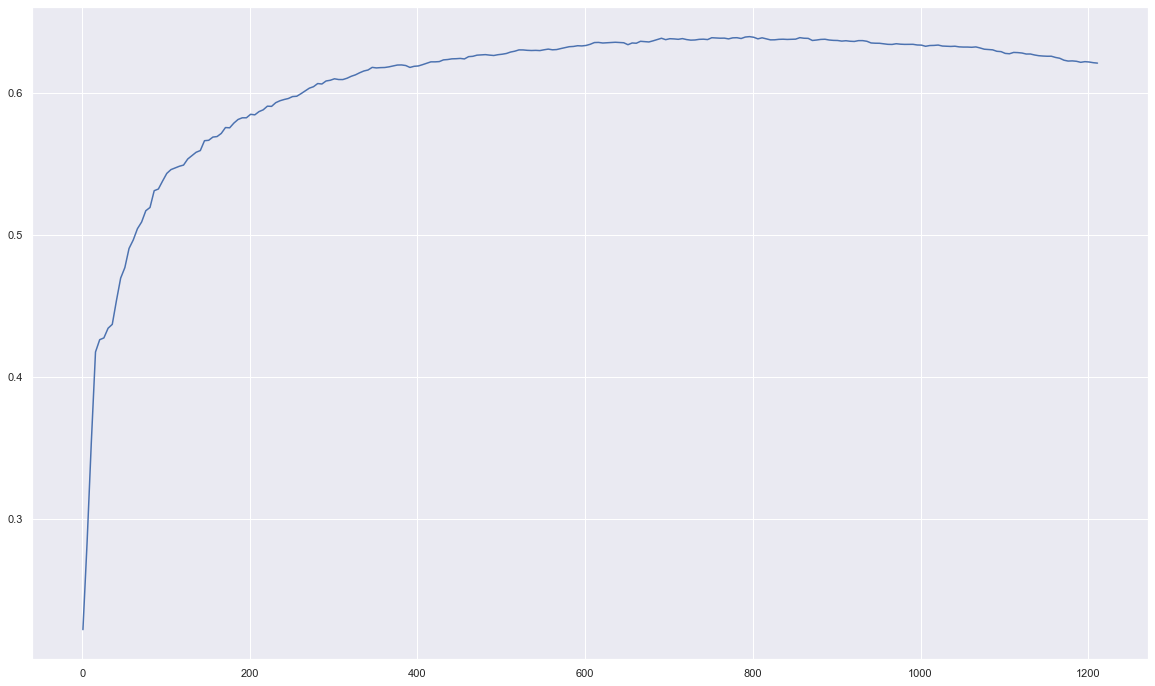

In [30]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(data=f1_results_unsupervised_unigram_bigram_chi_square)

In [31]:
# Getting the optimal number of features which will result in best mean cross validation F1-score from the dictionary

best_no_of_features= max(f1_results_unsupervised_unigram_bigram_chi_square, key=f1_results_unsupervised_unigram_bigram_chi_square.get)
best_no_of_features

796

In [32]:
# Extracting the optimal number of features into a dataframe for training

chi2_columns = chi2_df_sorted.columns[:best_no_of_features]
scaled_train_unsupervised_unigram_bigram_df_chi_square = train_unsupervised_unigram_bigram_chi_square_df[chi2_columns]
scaled_test_unsupervised_unigram_bigram_df_chi_square = test_unsupervised_unigram_bigram_chi_square_df[chi2_columns]

In [33]:
X_train = scaled_train_unsupervised_unigram_bigram_df_chi_square
X_test = scaled_test_unsupervised_unigram_bigram_df_chi_square

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 68.11%
Test Accuracy: 67.11%
Test F1 Score: 67.07%
Mean Cross Val Accuracy: 64.59%
Mean Cross Val F1 Score: 64.00%
Testing Matthew's coefficient: 0.382


# Unigrams + Bigrams + Supervised topics

In [34]:
# These topics are generated manually by observing highest frequency words.

def accident(text):
    wordlist=['die', 'death', 'kill', 'hit', 'crash', 'accident', 'insurance', 'drunk', 'drink', 'safety', 'speed', 'limit']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def change(text):
    wordlist=['change', 'replace', 'become', 'happen', 'transform']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def imagination_vs_reality(text):
    wordlist= ['reality', 'dream', 'imagine', 'imagination', 'challenge']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def law(text):
    wordlist=['policy', 'law', 'legal', 'government', 'state', 'regulation', 'license', 'approve', 'allow', 'rule', 
              'public']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def time(text):
    wordlist=['future', 'today', 'next', 'year', 'past', 'world']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def technology(text):
    wordlist=['technology', 'tech', 'robot', 'drone', 'machine', 'computer', 'robotic', 'program', 'ai', 'automobile', 
              'electric', 'system', 'information', 'data', 'automate']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def innovation(text):
    wordlist=['research', 'invent', 'innovation', 'innovate', 'invention', 'breakthrough', 'idea', 'develop', 
              'create', 'prototype', 'develop', 'build']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def business(text):
    wordlist=['money', 'invest', 'market', 'ceo', 'cost', 'buy', 'business', 'company']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0


def positive_words(text):
    wordlist=['get', 'want', 'cool', 'good', 'great', 'love', 'awesome', 'wow', 'perfect', 'solve', 'solution', 
              'excite', 'fun', 'safe', 'help', 'best', 'hope', 'lead']
              
    double_words=['look forward', 'cant wait']
    
    count=0
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            count+=1
            wordlist.remove(word)
    
    for phrase in double_words:
        if phrase in text:
            count+=1
              
    return count
              
              

def bad_words(text):
    wordlist=['never', 'fuck', 'shit', 'hell', 'scary', 'wtf', 'freak', 'hate', 'wrong', 'worry', 'die', 
              'kill', 'bad', 'crazy', 'death', 'problem', 'dangerous']
    count=0
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            count+=1
            wordlist.remove(word)
    
    return count


#brands/places/transportation type/events/products
columns=['toyota', 'audi', 'tesla', 'apple', 'google', 'uber', 'ford', 'lexus', 'nissan', 'volvo', 'bmw', 'california', 
         'michigan', 'detroit', 'googleplex', 'dmv', 'ce', 'codecon', 'forbes', 
         'cnet', 'wsj', 'train', 'railway', 'cruise', 'road', 'taxi', 'truck', 'highway', 'bus', 'cab', 'bike', 'freeway',
         'googlecar', 'camera', 'ego']

double_words=['ann arbor', 'silicon valley', 'google map', 'google glass']

def get_column_value(text, word):
    wordlist=text.split(' ')
    if word in wordlist:
        return 1
    return 0

def get_double_value(text, phrase):
    if phrase in text:
        return 1
    return 0

In [35]:
df_train_supervised_unigram_bigram=df.copy()
df_test_supervised_unigram_bigram=test_df.copy()

In [36]:
for word in columns:
    df_train_supervised_unigram_bigram['topic ' + word]=df_train_supervised_unigram_bigram.apply(lambda x: get_column_value(x['lemmatized and stopwords_removed'], word), axis=1)
    df_test_supervised_unigram_bigram['topic ' + word]=df_test_supervised_unigram_bigram.apply(lambda x: get_column_value(x['lemmatized and stopwords_removed'], word), axis=1)
for phrase in double_words:
    df_train_supervised_unigram_bigram['topic ' + phrase]=df_train_supervised_unigram_bigram.apply(lambda x: get_double_value(x['lemmatized and stopwords_removed'], phrase), axis=1)
    df_test_supervised_unigram_bigram['topic ' + phrase]=df_test_supervised_unigram_bigram.apply(lambda x: get_column_value(x['lemmatized and stopwords_removed'], word), axis=1)

In [37]:
# train dataset
df_train_supervised_unigram_bigram['topic accident']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(accident)
df_train_supervised_unigram_bigram['topic change']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(change)
df_train_supervised_unigram_bigram['topic imagination_vs_reality']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(imagination_vs_reality)
df_train_supervised_unigram_bigram['topic law']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(law)
df_train_supervised_unigram_bigram['topic time']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(time)
df_train_supervised_unigram_bigram['topic technology']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(technology)
df_train_supervised_unigram_bigram['topic innovation']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(innovation)
df_train_supervised_unigram_bigram['topic business']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(business)

df_train_supervised_unigram_bigram['topic positive_words']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(positive_words)
df_train_supervised_unigram_bigram['topic bad_words']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(bad_words)
df_train_supervised_unigram_bigram['topic net positive']=df_train_supervised_unigram_bigram['topic positive_words']-df_train_supervised_unigram_bigram['topic bad_words']



# test dataset

df_test_supervised_unigram_bigram['topic accident']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(accident)
df_test_supervised_unigram_bigram['topic change']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(change)
df_test_supervised_unigram_bigram['topic imagination_vs_reality']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(imagination_vs_reality)
df_test_supervised_unigram_bigram['topic law']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(law)
df_test_supervised_unigram_bigram['topic time']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(time)
df_test_supervised_unigram_bigram['topic technology']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(technology)
df_test_supervised_unigram_bigram['topic innovation']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(innovation)
df_test_supervised_unigram_bigram['topic business']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(business)

df_test_supervised_unigram_bigram['topic positive_words']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(positive_words)
df_test_supervised_unigram_bigram['topic bad_words']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(bad_words)
df_test_supervised_unigram_bigram['topic net positive']=df_test_supervised_unigram_bigram['topic positive_words']-df_test_supervised_unigram_bigram['topic bad_words']

## Without Chi Square Feature Selection

## Preparing data for model training

In [38]:
# Scaling the Supervised topics

scaler = MinMaxScaler()
scaled_train_supervised_unigram_bigram = scaler.fit_transform(df_train_supervised_unigram_bigram.iloc[:, 3:])
scaled_test_supervised_unigram_bigram = scaler.transform(df_test_supervised_unigram_bigram.iloc[:, 3:])

# Transforming scaled topics into a dataframe

scaled_train_supervised_unigram_bigram_df = pd.DataFrame(scaled_train_supervised_unigram_bigram, columns = df_train_supervised_unigram_bigram.iloc[:, 3:].columns)
scaled_test_supervised_unigram_bigram_df = pd.DataFrame(scaled_test_supervised_unigram_bigram, columns = df_test_supervised_unigram_bigram.iloc[:, 3:].columns)

# Combining Unigrams + Bigrams + Unsupervised topics into one dataframe

train_supervised_unigram_bigram = pd.concat([scaled_train_supervised_unigram_bigram_df, df_vectorized_text_unigrams_and_bigrams_train], axis=1)
test_supervised_unigram_bigram = pd.concat([scaled_test_supervised_unigram_bigram_df, df_vectorized_text_unigrams_and_bigrams_test], axis=1)

In [39]:
train_supervised_unigram_bigram.head(3)

,topic toyota,topic audi,topic tesla,topic apple,topic google,topic uber,topic ford,topic lexus,topic nissan,topic volvo,...,wrong,wtf,wwdc,yay,yeah,year,yes,yesterday,yr,zero
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
X_train = train_supervised_unigram_bigram
X_test = test_supervised_unigram_bigram

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 67.73%
Test Accuracy: 64.21%
Test F1 Score: 64.88%
Mean Cross Val Accuracy: 61.88%
Mean Cross Val F1 Score: 61.50%
Testing Matthew's coefficient: 0.357


## Training with Chi Square Feature Selection

## Preparing data for model training

In [41]:
# Scaling the Supervised topics

scaler = MinMaxScaler()
scaled_train_supervised_unigram_bigram_chi_square = scaler.fit_transform(df_train_supervised_unigram_bigram.iloc[:, 3:])
scaled_test_supervised_unigram_bigram_chi_square = scaler.transform(df_test_supervised_unigram_bigram.iloc[:, 3:])

# Transforming scaled topics into a dataframe

scaled_train_supervised_unigram_bigram_chi_square_df = pd.DataFrame(scaled_train_supervised_unigram_bigram_chi_square, columns = df_train_supervised_unigram_bigram.iloc[:, 3:].columns)
scaled_test_supervised_unigram_bigram_chi_square_df = pd.DataFrame(scaled_test_supervised_unigram_bigram_chi_square, columns = df_test_supervised_unigram_bigram.iloc[:, 3:].columns)

# Combining Unigrams + Bigrams + Unsupervised topics into one dataframe

train_supervised_unigram_bigram_chi_square_df = pd.concat([scaled_train_supervised_unigram_bigram_chi_square_df, df_vectorized_text_unigrams_and_bigrams_train], axis=1)
test_supervised_unigram_bigram_chi_square_df = pd.concat([scaled_test_supervised_unigram_bigram_chi_square_df, df_vectorized_text_unigrams_and_bigrams_test], axis=1)

In [42]:
# 0 is chi2 score, 1 is p-value
X_train = train_supervised_unigram_bigram_chi_square_df
X_test = test_supervised_unigram_bigram_chi_square_df

chi2_values = chi2(X_train.values, y_train)
chi2_df = pd.DataFrame(data=chi2_values, columns=X_train.columns)
chi2_df_sorted = chi2_df.sort_values(by=0, axis = 1, ascending = False)
chi2_df_sorted

,topic positive_words,topic bad_words,cool,wait,topic accident,topic uber,topic california,problem,topic law,want,...,bike,google plan,feel lucky,enter,pay,early,student,steve,topic forbes,topic ego
0,1.995799e+02,1.249367e+02,8.708846e+01,5.723568e+01,4.921189e+01,4.242499e+01,4.090031e+01,3.701021e+01,3.677485e+01,3.670220e+01,...,0.018184,0.017357,0.016723,0.015785,0.012140,0.010780,0.005156,0.003583,NaN,NaN
1,4.589603e-44,7.419002e-28,1.227383e-19,3.727611e-13,2.059558e-11,6.130992e-10,1.314045e-09,9.190396e-09,1.033817e-08,1.072059e-08,...,0.990949,0.991359,0.991673,0.992139,0.993949,0.994625,0.997425,0.998210,NaN,NaN


In [43]:
## Finding the optimal number of features to use based on cross validation F1-score

f1_results_unigram_bigram_supervised = {}
for n in range(1, 1250, 5):
    chi2_columns_unigram_bigram_supervised = chi2_df_sorted.columns[:n]
    X_train_df = train_supervised_unigram_bigram_chi_square_df[chi2_columns_unigram_bigram_supervised]

    #train MLR
    clf = MultinomialNB()

    #Cross validation, cv=5
    f1 = cross_val_score(clf, X_train_df, y_train, scoring='f1_weighted', cv=5)
    
    #Storing mean cross validation F1-scores in a dictionary
    f1_results_unigram_bigram_supervised[n] = f1.mean() 

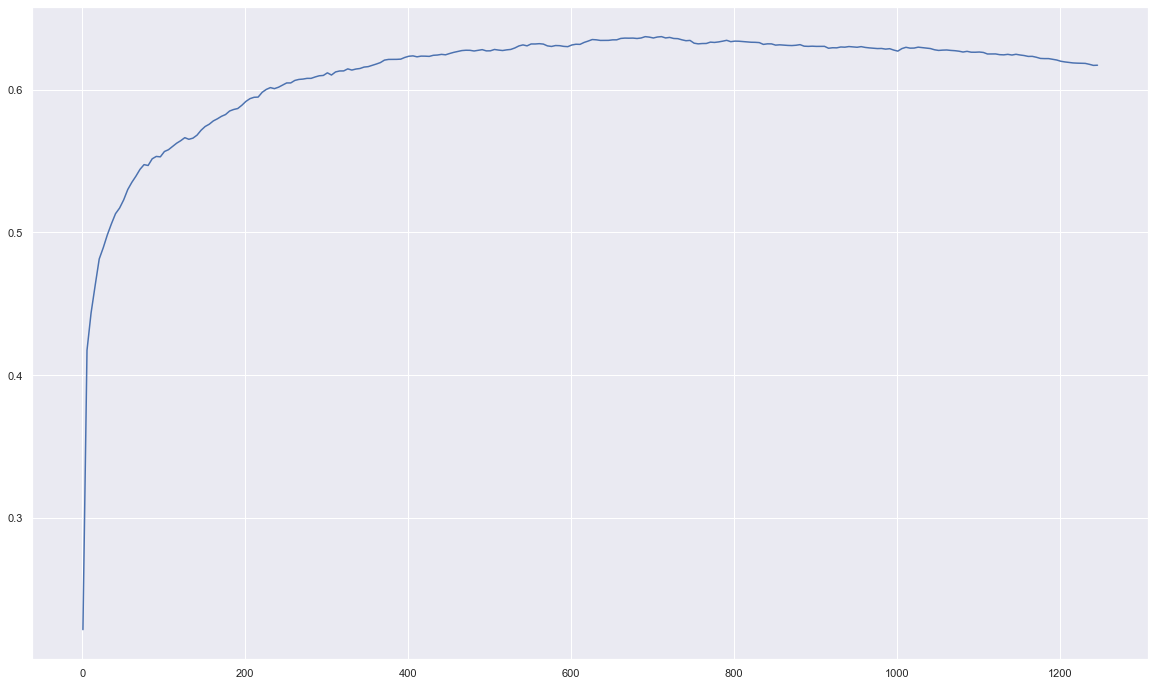

In [44]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(data=f1_results_unigram_bigram_supervised)

In [45]:
# Getting the optimal number of features which will result in best mean cross validation F1-score from the dictionary

best_no_of_features= max(f1_results_unigram_bigram_supervised, key=f1_results_unigram_bigram_supervised.get)
best_no_of_features

711

In [46]:
# Extracting the optimal number of features into a dataframe for training

chi2_columns = chi2_df_sorted.columns[:best_no_of_features]
scaled_train_supervised_unigram_bigram_df_chi_square = train_supervised_unigram_bigram_chi_square_df[chi2_columns]
scaled_test_supervised_unigram_bigram_df_chi_square = test_supervised_unigram_bigram_chi_square_df[chi2_columns]

In [47]:
X_train = scaled_train_supervised_unigram_bigram_df_chi_square
X_test = scaled_test_supervised_unigram_bigram_df_chi_square

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 66.80%
Test Accuracy: 65.85%
Test F1 Score: 66.07%
Mean Cross Val Accuracy: 64.03%
Mean Cross Val F1 Score: 63.50%
Testing Matthew's coefficient: 0.367
